# Imports

In [157]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP.models import ModelSpec as MS

from sklearn.model_selection import (train_test_split,
                                     StratifiedKFold,
                                     cross_val_score,
                                     validation_curve)
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             roc_auc_score,
                             roc_curve,
                             log_loss,
                             confusion_matrix)
from sklearn.ensemble import \
     (BaggingClassifier as BC,
      RandomForestClassifier as RF,
      GradientBoostingClassifier as GBR)
from ISLP.bart import BART

# Plotting
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
RNG_SEED = 111
np.random.seed(RNG_SEED)

# Extracting a pandas DataFrame from our CSV Data
We want to remove all columns with missing data, but first we have to remove the Precipitation column, because we only care about whether it rains tomorrow, not today.

We'll also replace our date column with a new column of categorical data, specifying if it is the wet season (Oct thru Apr) or the dry season (May thru September)

In [158]:
Weather = pd.read_csv('balanced_set.csv')
Weather = Weather.assign(
    will_rain = pd.Categorical(
        ['No' if rain == 0 else 'Yes' for rain in Weather['rain']],
        categories=['No', 'Yes'])
    ).drop('rain', axis='columns').drop('precip', axis='columns'
    ).drop('DATE', axis='columns').dropna()
print(Weather.shape)

(1222, 5)


# Simple Exploratory Data Analysis

In [159]:
Weather.describe().T

,count,mean,std,min,25%,50%,75%,max
humidity,1222.0,69.789689,10.971520,23.00,65.00,72.00,77.00,95.00
wind_speed,1222.0,6.052455,2.473229,1.80,4.50,5.80,7.00,21.60
sea_pressure,1222.0,29.995360,0.102928,29.57,29.93,29.99,30.06,30.29
min_temp,1222.0,57.964812,7.290817,38.00,53.00,58.00,63.00,78.00


In [160]:
will_rain = Weather['will_rain'] == 'Yes'
yes_rain_data = Weather[will_rain]
no_rain_data = Weather[~will_rain]

yes_rain_data.describe().T

,count,mean,std,min,25%,50%,75%,max
humidity,611.0,72.006547,8.841962,30.00,67.00,73.00,78.00,95.00
wind_speed,611.0,7.020949,2.783002,1.90,5.20,6.50,8.40,21.60
sea_pressure,611.0,29.993568,0.105858,29.57,29.93,29.99,30.07,30.28
min_temp,611.0,56.729951,6.086594,38.00,53.00,56.00,60.00,78.00


In [161]:
no_rain_data.describe().T

,count,mean,std,min,25%,50%,75%,max
humidity,611.0,67.572831,12.366103,23.00,64.00,71.00,76.00,87.00
wind_speed,611.0,5.083961,1.618521,1.80,3.90,5.10,6.10,10.90
sea_pressure,611.0,29.997152,0.099968,29.75,29.93,29.98,30.06,30.29
min_temp,611.0,59.199673,8.142344,38.00,54.00,61.00,66.00,74.00


# Building a Simple Decision Tree Model

In [162]:
X = Weather.drop('will_rain', axis='columns')
y = Weather['will_rain']
print(X.dtypes)

# Training/Test Split
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(X, y, test_size=0.2, random_state=RNG_SEED)

X_test = np.asarray(X_test)

model = MS(X_train, intercept=False)
D = model.fit_transform(X_train, y_train)
predictors = list(D.columns)
clf_test = DTC(criterion='gini',
               max_depth=3,
               random_state=RNG_SEED)
X_train = np.asarray(D)
clf_test.fit(X_train, y_train)

humidity        float64
wind_speed      float64
sea_pressure    float64
min_temp        float64
dtype: object


,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,111
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


# Trying out a Decision Tree built from the full training set

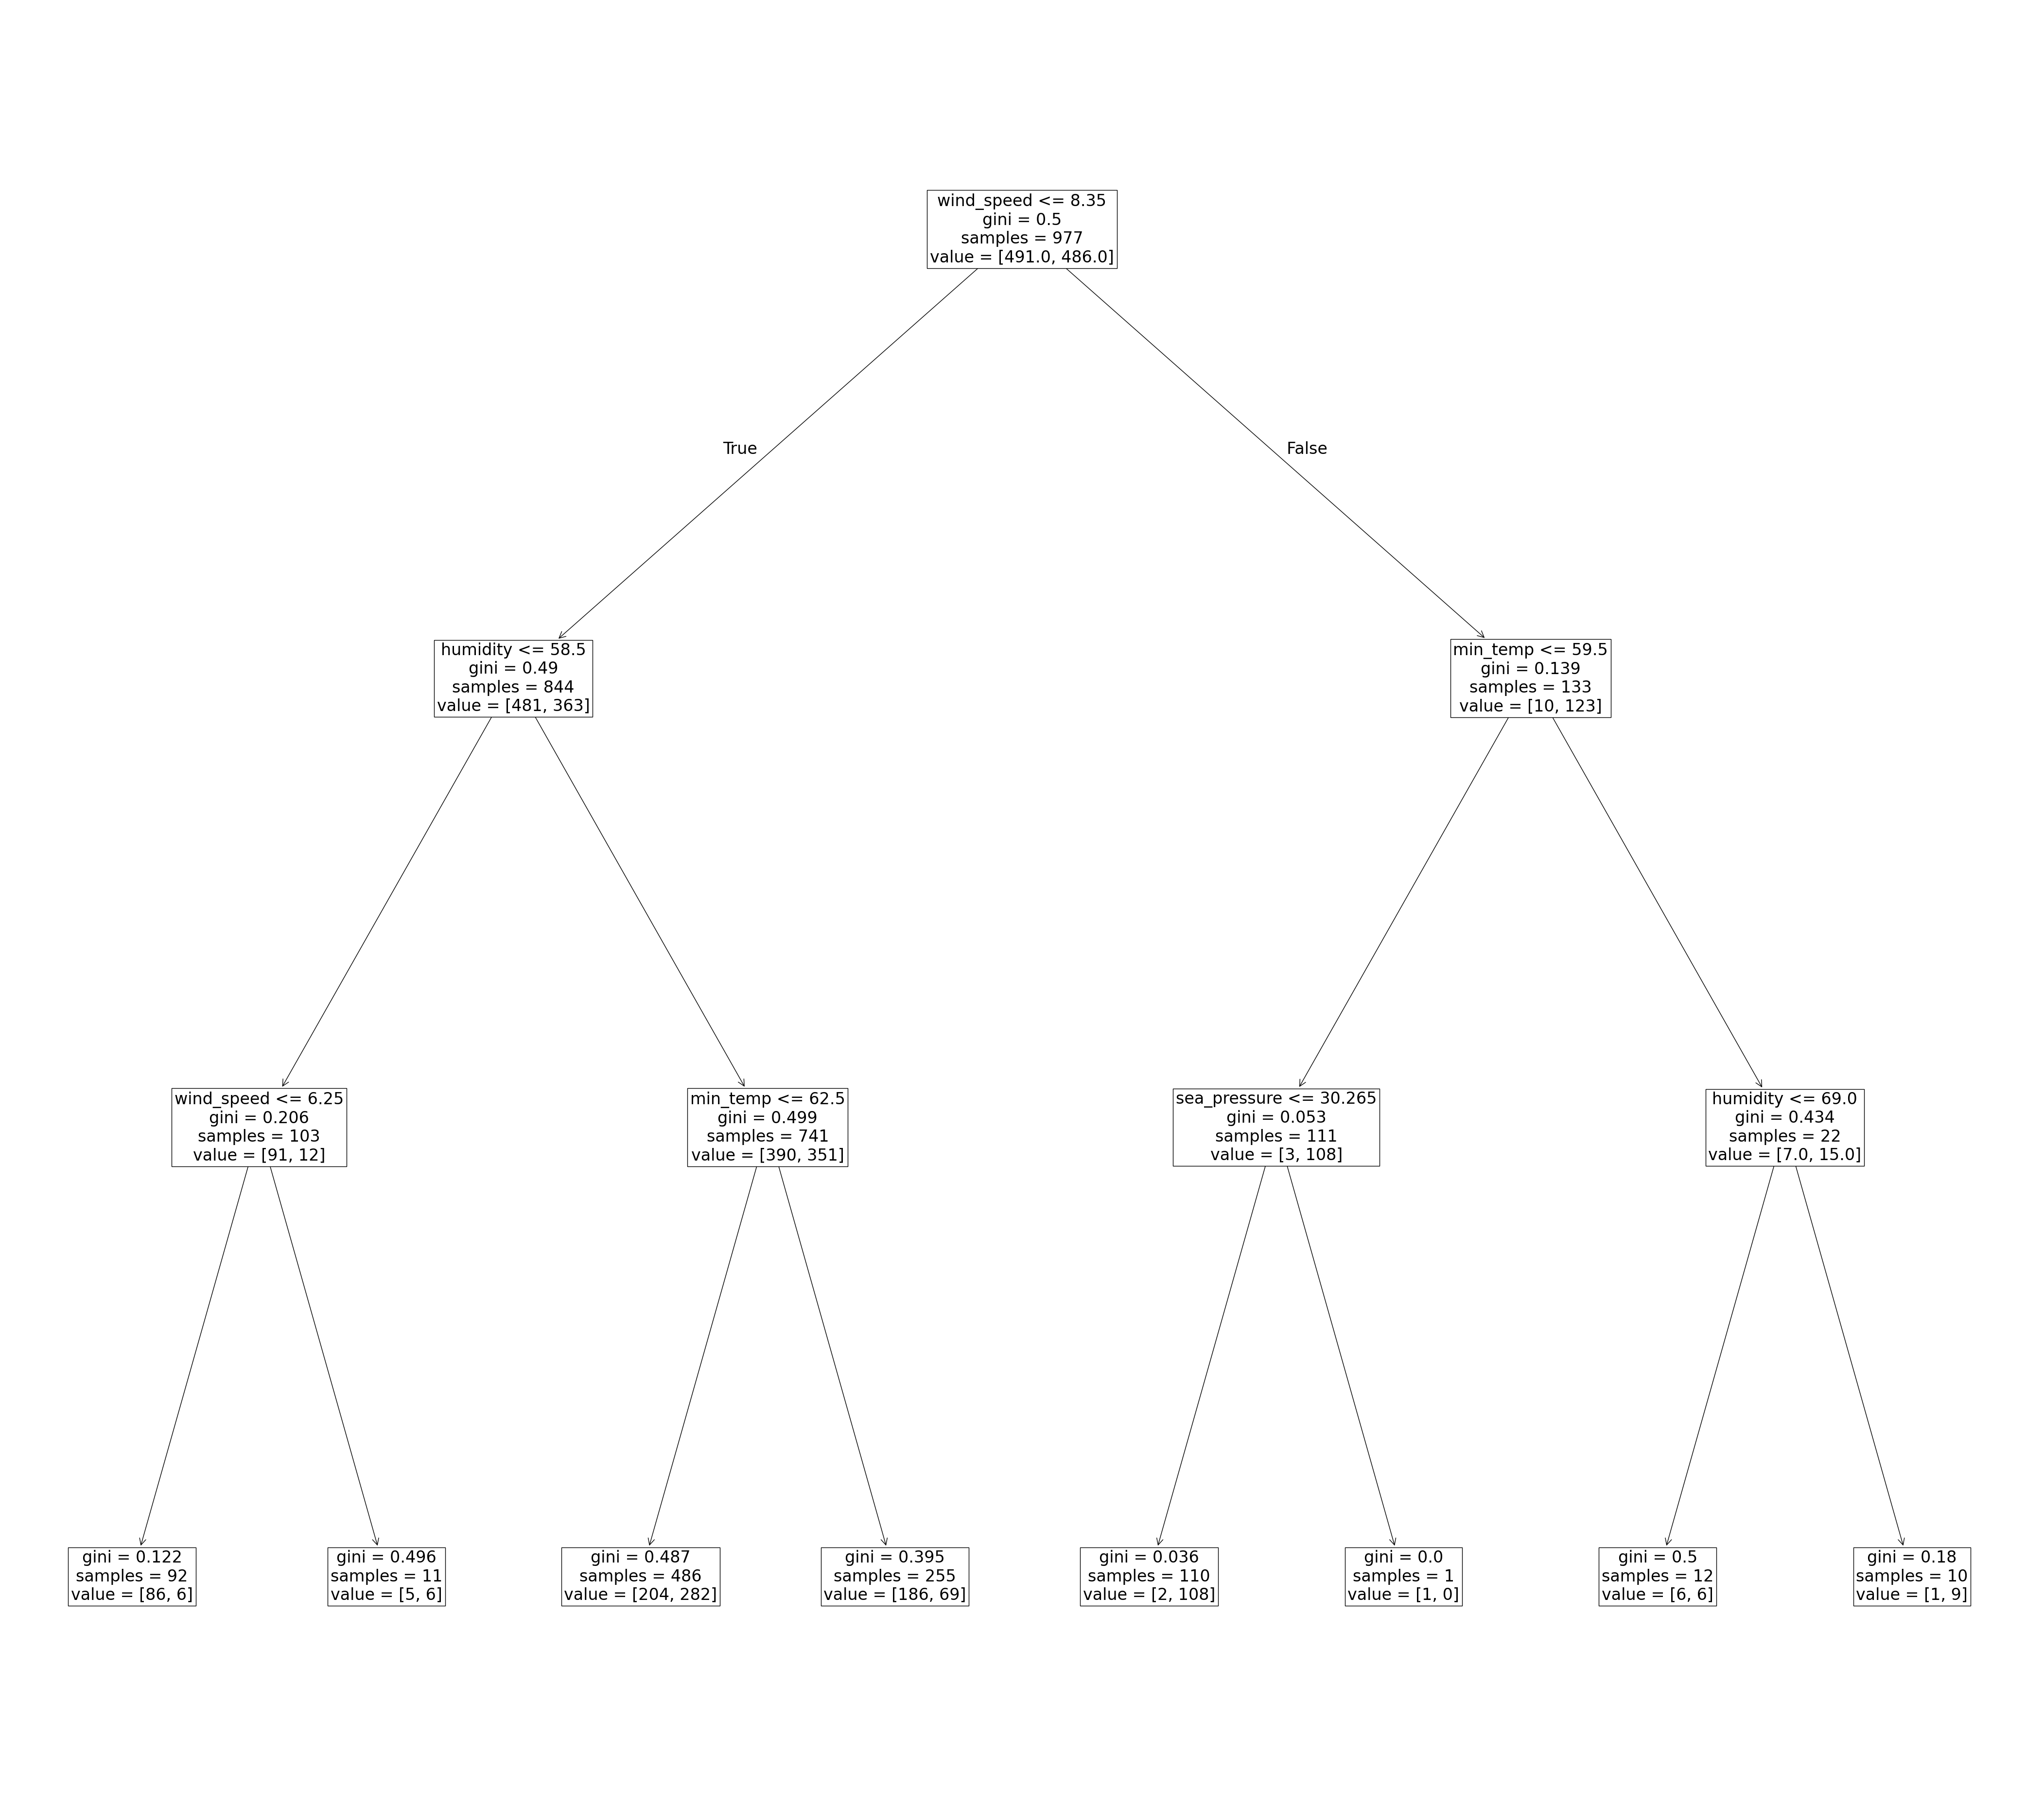

In [163]:
fig, ax = subplots(figsize=(54,48))
plot_tree(clf_test,
          feature_names=predictors,
          fontsize=24,
          ax=ax)
fig.savefig('fig1.png')

# Using pruning and cross-validation to select optimal tree parameters

Unpruned Model Training Error: 0.0
Naive Bayes Training Error: 0.4980793854033291
Unpruned Model Test Error: 0.326530612244898
Naive Bayes Test Error: 0.47959183673469385


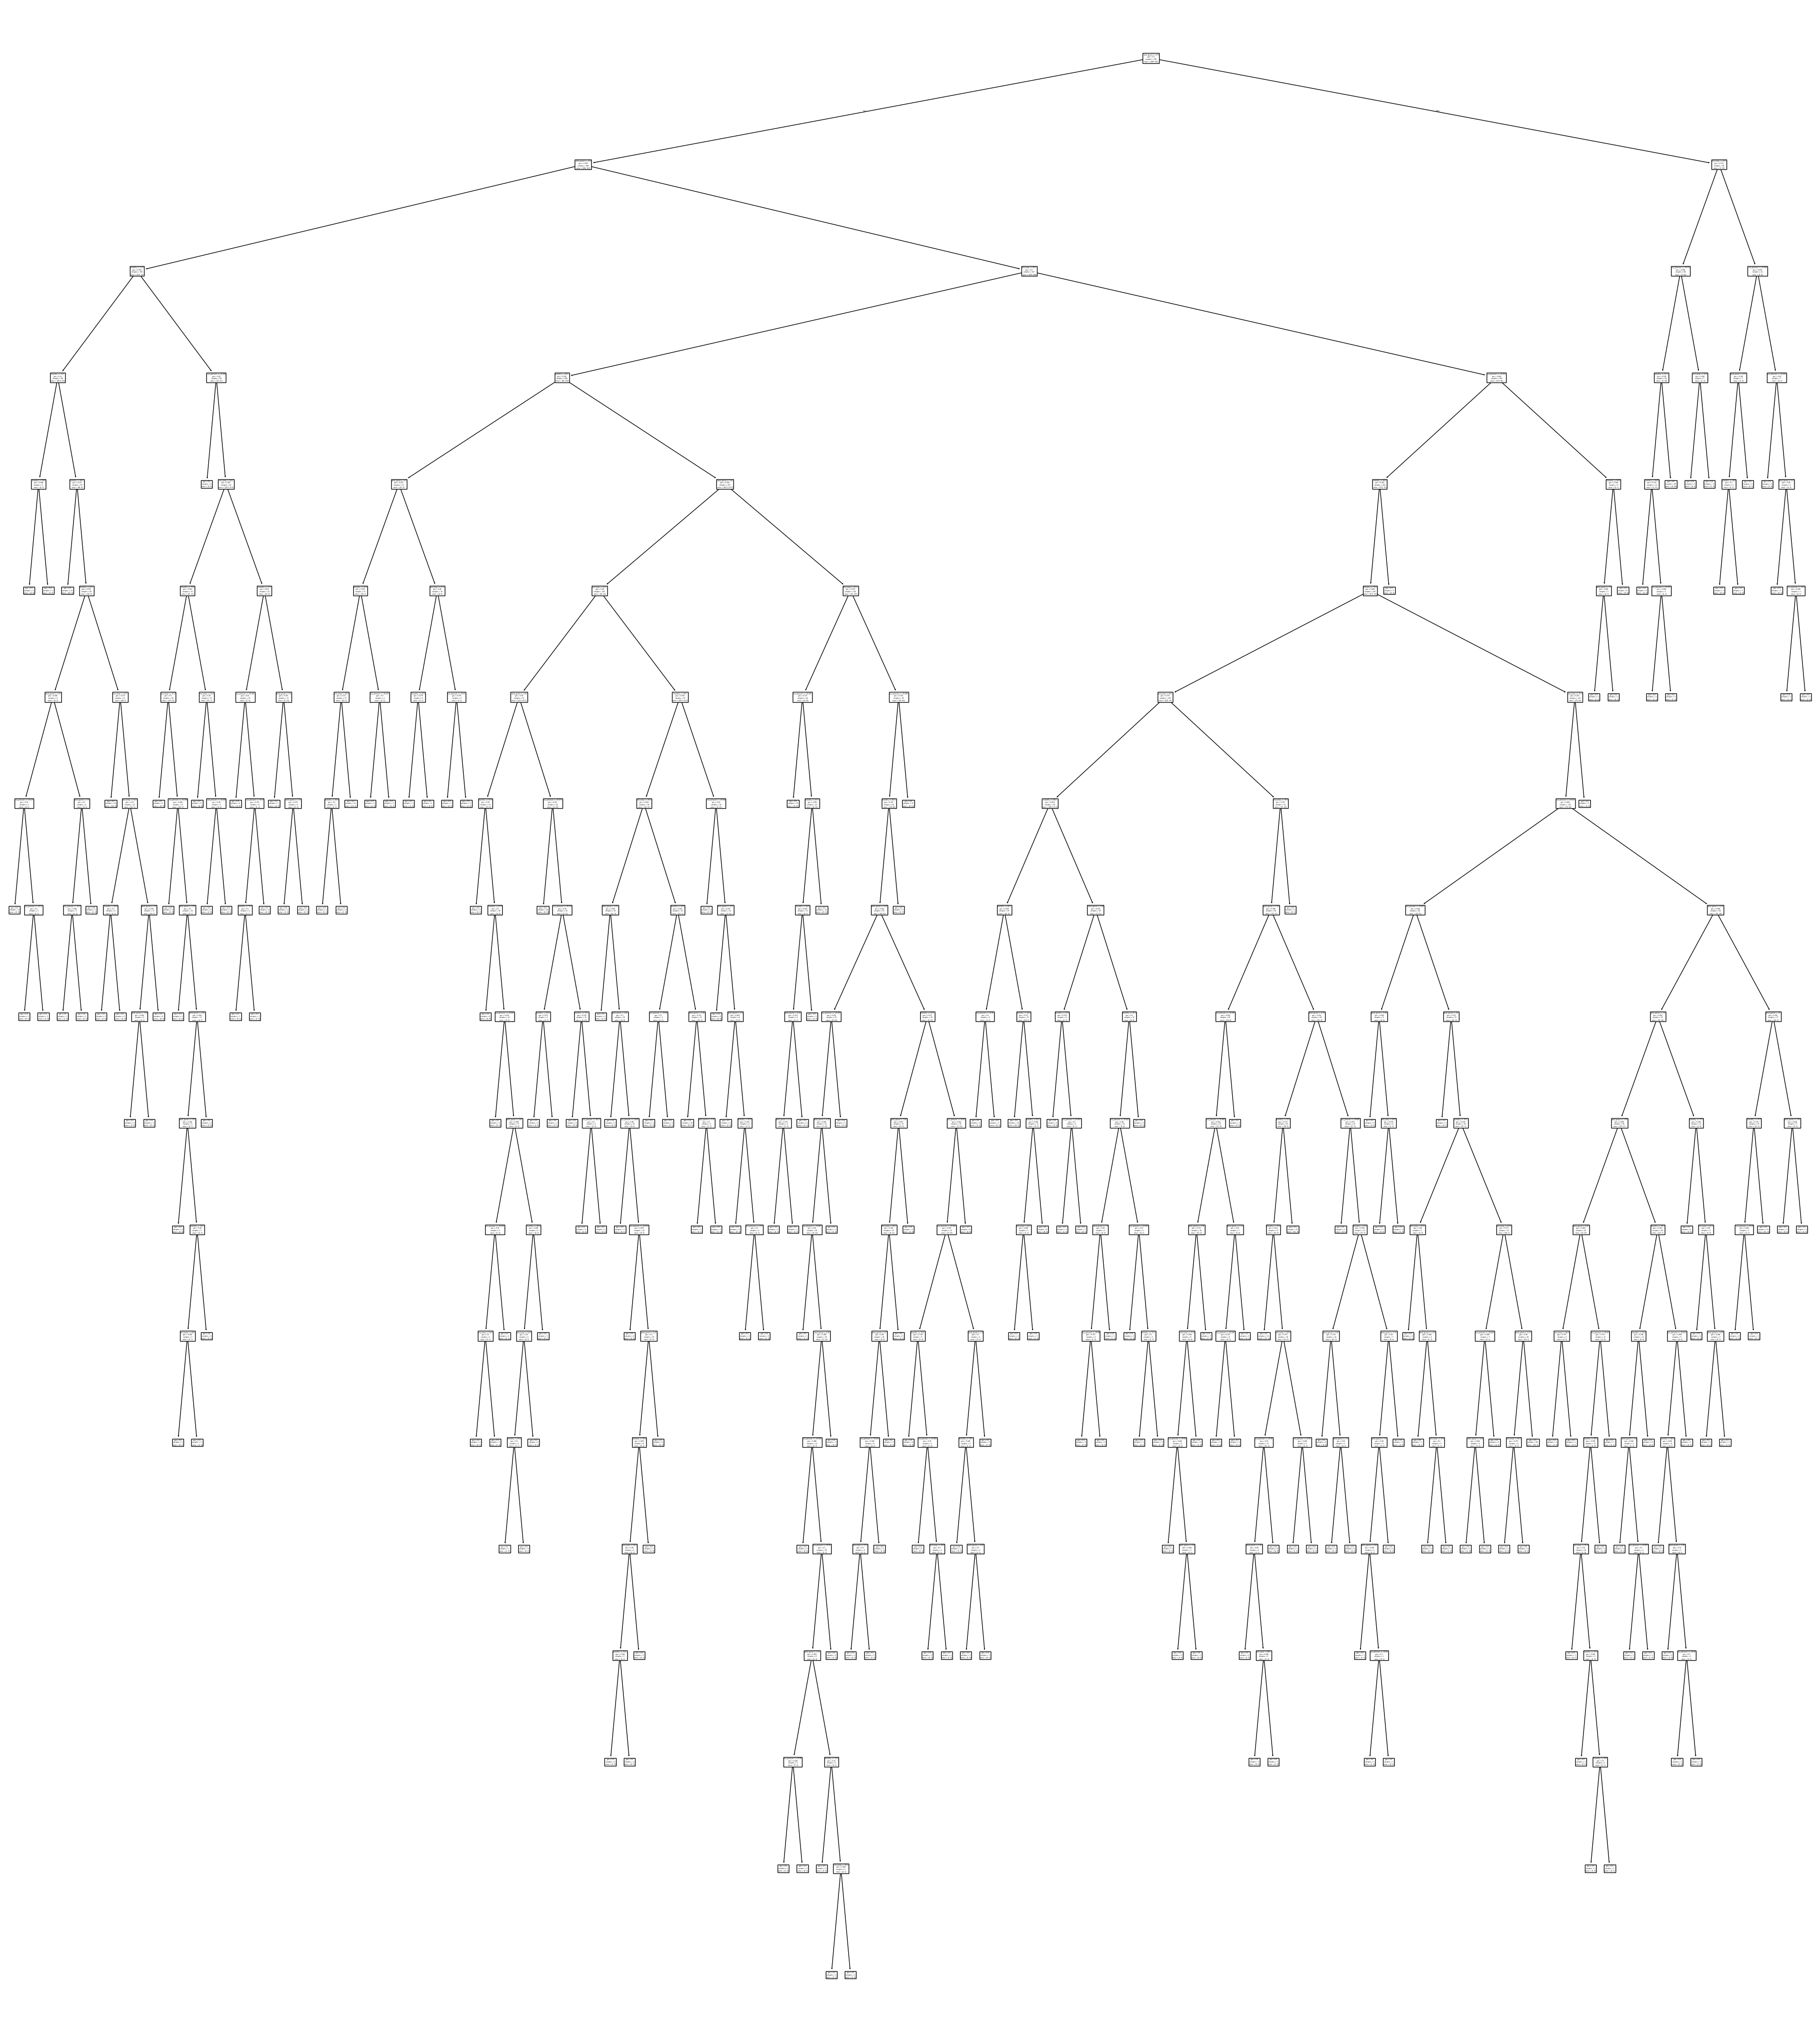

In [164]:
# Further training/test split to avoid using the held-out test set
(X_train_s,
 X_test_s,
 y_train_s,
 y_test_s) = train_test_split(X_train, y_train, test_size=0.2, random_state=RNG_SEED+1)

clf_s = DTC(criterion='gini', random_state=RNG_SEED)
clf_s.fit(X_train_s, y_train_s)

# Plot the unpruned tree
fig, ax = subplots(figsize=(48,54))
plot_tree(clf_s,
          feature_names=predictors,
          ax=ax);

fig.savefig("fig6.png")

err_unp_train_s = 1 - accuracy_score(y_train_s, clf_s.predict(X_train_s))
err_bayes_train_s = 1 - accuracy_score(y_train_s, ['Yes'] * len(y_train_s))
err_unp_test_s = 1 - accuracy_score(y_test_s, clf_s.predict(X_test_s))
err_bayes_test_s = 1 - accuracy_score(y_test_s, ['No'] * len(y_test_s))

print("Unpruned Model Training Error: " + str(err_unp_train_s))
print("Naive Bayes Training Error: " + str(err_bayes_train_s))

print("Unpruned Model Test Error: " + str(err_unp_test_s))
print("Naive Bayes Test Error: " + str(err_bayes_test_s))

In [165]:
ccp_path_s = clf_s.cost_complexity_pruning_path(X_train_s, y_train_s)
kfold = skm.KFold(10,
                  random_state=RNG_SEED,
                  shuffle=True)
grid_ccp_s = skm.GridSearchCV(clf_s,
                              {'ccp_alpha': ccp_path_s.ccp_alphas},
                              refit=True,
                              cv=kfold,
                              scoring='accuracy')
grid_ccp_s.fit(X_train_s, y_train_s)

,estimator,DecisionTreeC...dom_state=111)
,param_grid,{'ccp_alpha': array([0. ... 0.05223728])}
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [166]:
ccp_cv = 1 - grid_ccp_s.best_score_

print("Best CV Error:", ccp_cv)

Best CV Error: 0.2855079519636481


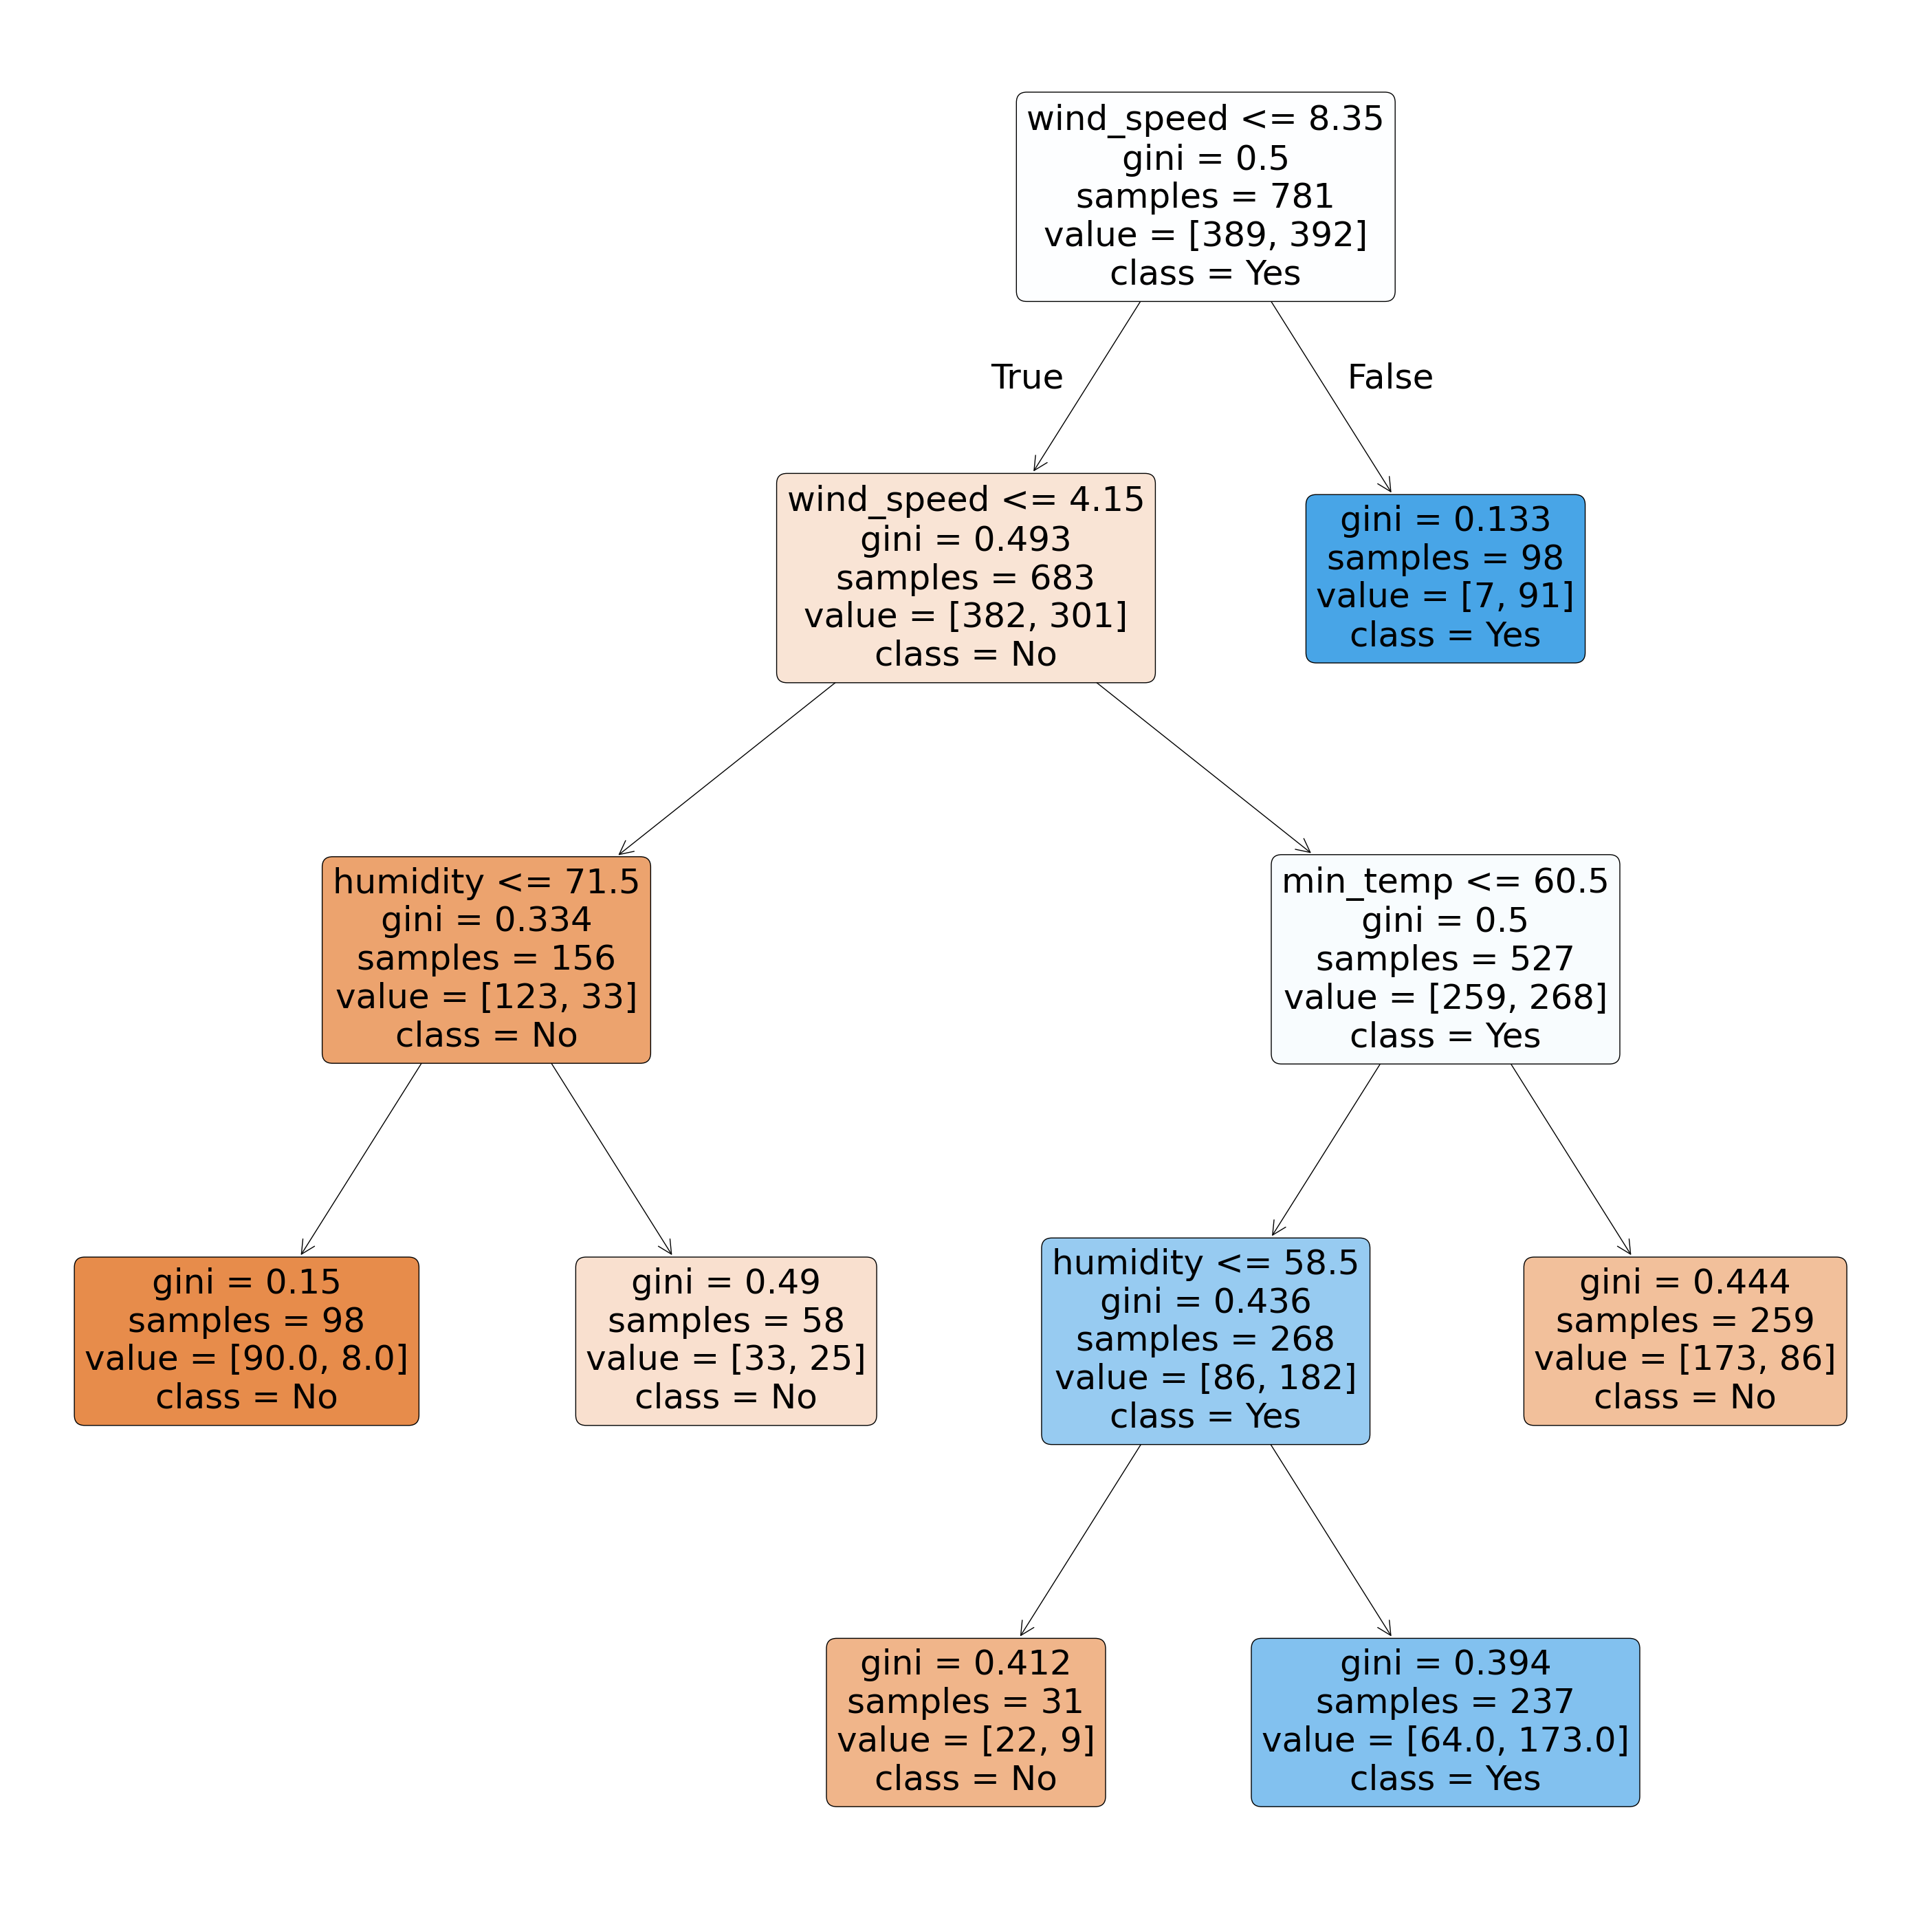

In [167]:
fig, ax = subplots(figsize=(36,36))
best_ccp_s = grid_ccp_s.best_estimator_
plot_tree(best_ccp_s,
          feature_names=predictors,
          ax=ax,
          class_names=['No', 'Yes'],
          rounded=True,
          filled=True,
         fontsize=36);
fig.savefig("fig4.png")

In [168]:
err_ccp_train_s = 1 - accuracy_score(y_train_s, best_ccp_s.predict(X_train_s))
err_ccp_test_s = 1 - accuracy_score(y_test_s, best_ccp_s.predict(X_test_s))

print("Model Training Error: " + str(err_ccp_train_s))
print("Naive Bayes Training Error: " + str(err_bayes_train_s))

print("Model Test Error: " + str(err_ccp_test_s))
print("Naive Bayes Test Error: " + str(err_bayes_test_s))
confusion_ccp_s = confusion_matrix(best_ccp_s.predict(X_test_s),
                                   y_test_s)


confusion_ccp_s

Model Training Error: 0.25480153649167736
Naive Bayes Training Error: 0.4980793854033291
Model Test Error: 0.2551020408163265
Naive Bayes Test Error: 0.47959183673469385


array([[78, 26],
       [24, 68]])

# Making a graph of alpha value vs. CV error

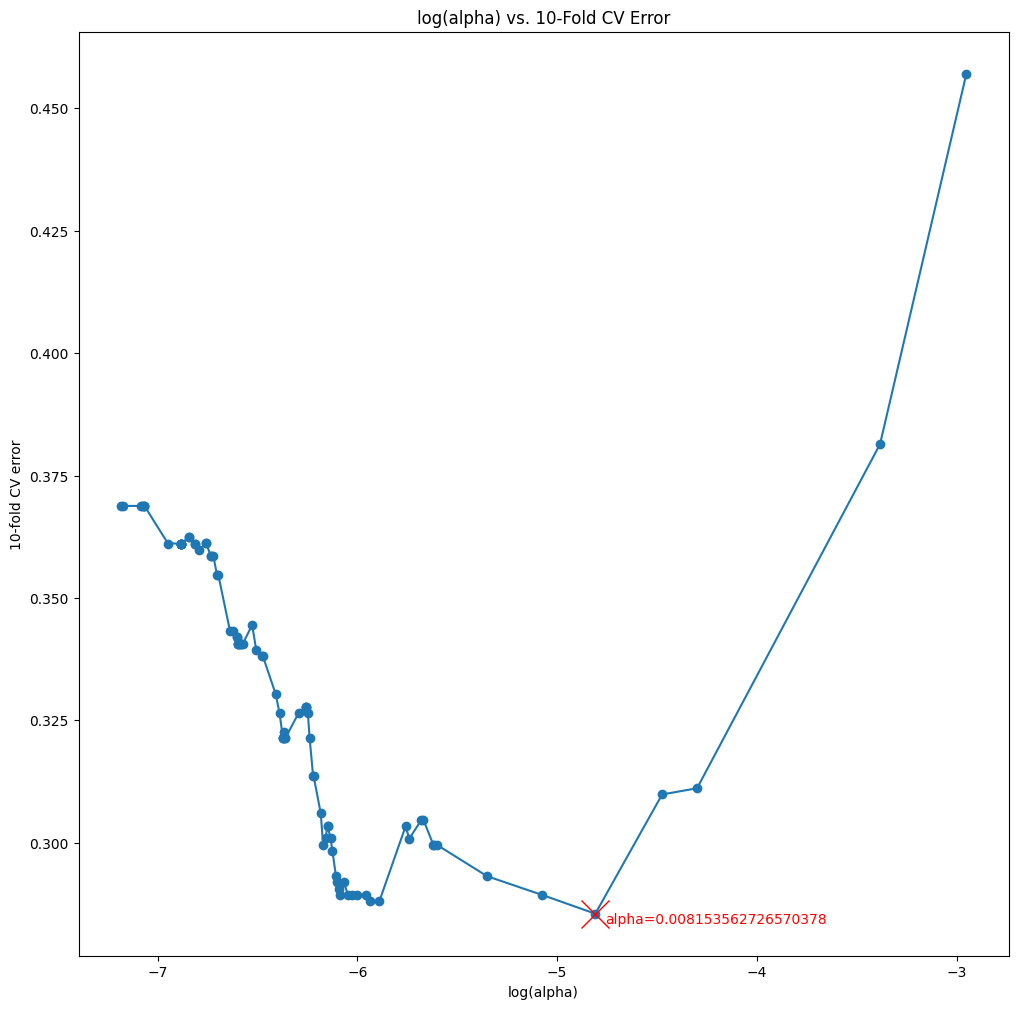

In [169]:
cv_df_ccp_s = pd.DataFrame(grid_ccp_s.cv_results_)
alpha_list_s = np.log([alpha_dict['ccp_alpha'] for alpha_dict in cv_df_ccp_s['params'][1::]])
err_list_s = [1 - acc for acc in cv_df_ccp_s['mean_test_score'][1::]]
min_err_s = min(err_list_s)
min_ind_s = err_list_s.index(min_err_s)
best_alpha_s = alpha_list_s[min_ind_s]

plt.figure(figsize=(12,12))

plt.plot(alpha_list_s, err_list_s, marker='o')
plt.plot(best_alpha_s, min_err_s, marker='x', markersize=20, color='red')
plt.text(best_alpha_s+0.05, min_err_s - 0.002, "alpha=" + str(np.exp(best_alpha_s)), fontsize=10, color='red')
plt.xlabel("log(alpha)"); plt.ylabel("10-fold CV error"); plt.title("log(alpha) vs. 10-Fold CV Error")
plt.savefig("fig2.png");
plt.show();




# Plotting Baseline/Model Training/Test Error

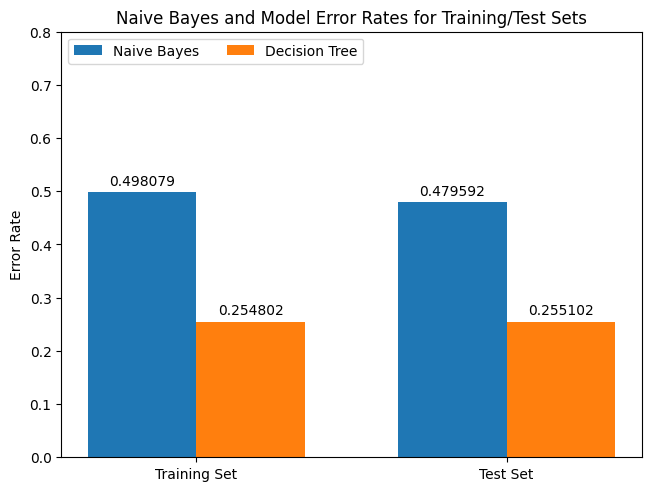

In [170]:
error_sets_ccp_s = ("Training Set", "Test Set")
errors_ccp_s = {
    'Naive Bayes': (err_bayes_train_s, err_bayes_test_s),
    'Decision Tree': (err_ccp_train_s, err_ccp_test_s)
}

x = np.arange(len(error_sets_ccp_s))
width = 0.35
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in errors_ccp_s.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Error Rate')
ax.set_title('Naive Bayes and Model Error Rates for Training/Test Sets')
ax.set_xticks(x + width/2, error_sets_ccp_s)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 0.8)
fig.savefig("fig5.png")

plt.show()

# ROC-AUC

Test ROC-AUC: 0.7906758448060075


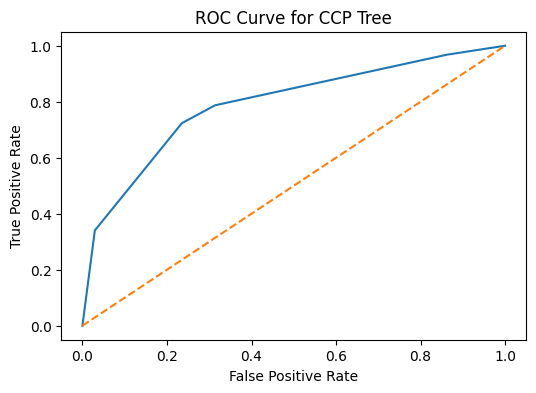

In [171]:
prob_test_ccp_s = best_ccp_s.predict_proba(X_test_s)[:,1]
auc_ccp = roc_auc_score(y_test_s, prob_test_ccp_s)

print("Test ROC-AUC: " + str(roc_auc_score(y_test_s, prob_test_ccp_s)))

fpr_ccp, tpr_ccp = roc_curve(y_test_s, prob_test_ccp_s,
                             pos_label="Yes")[:2]
fig, ax = subplots(figsize=(6,4))
ax.plot(fpr_ccp, tpr_ccp)
ax.plot([0,1], [0,1], linestyle='--')
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
ax.set_title("ROC Curve for CCP Tree")
fig.savefig("fig9.png")

plt.show()

# Fitting the full model on the entire training set

Unpruned Model Training Error: 0.0
Naive Bayes Training Error: 0.4974411463664279


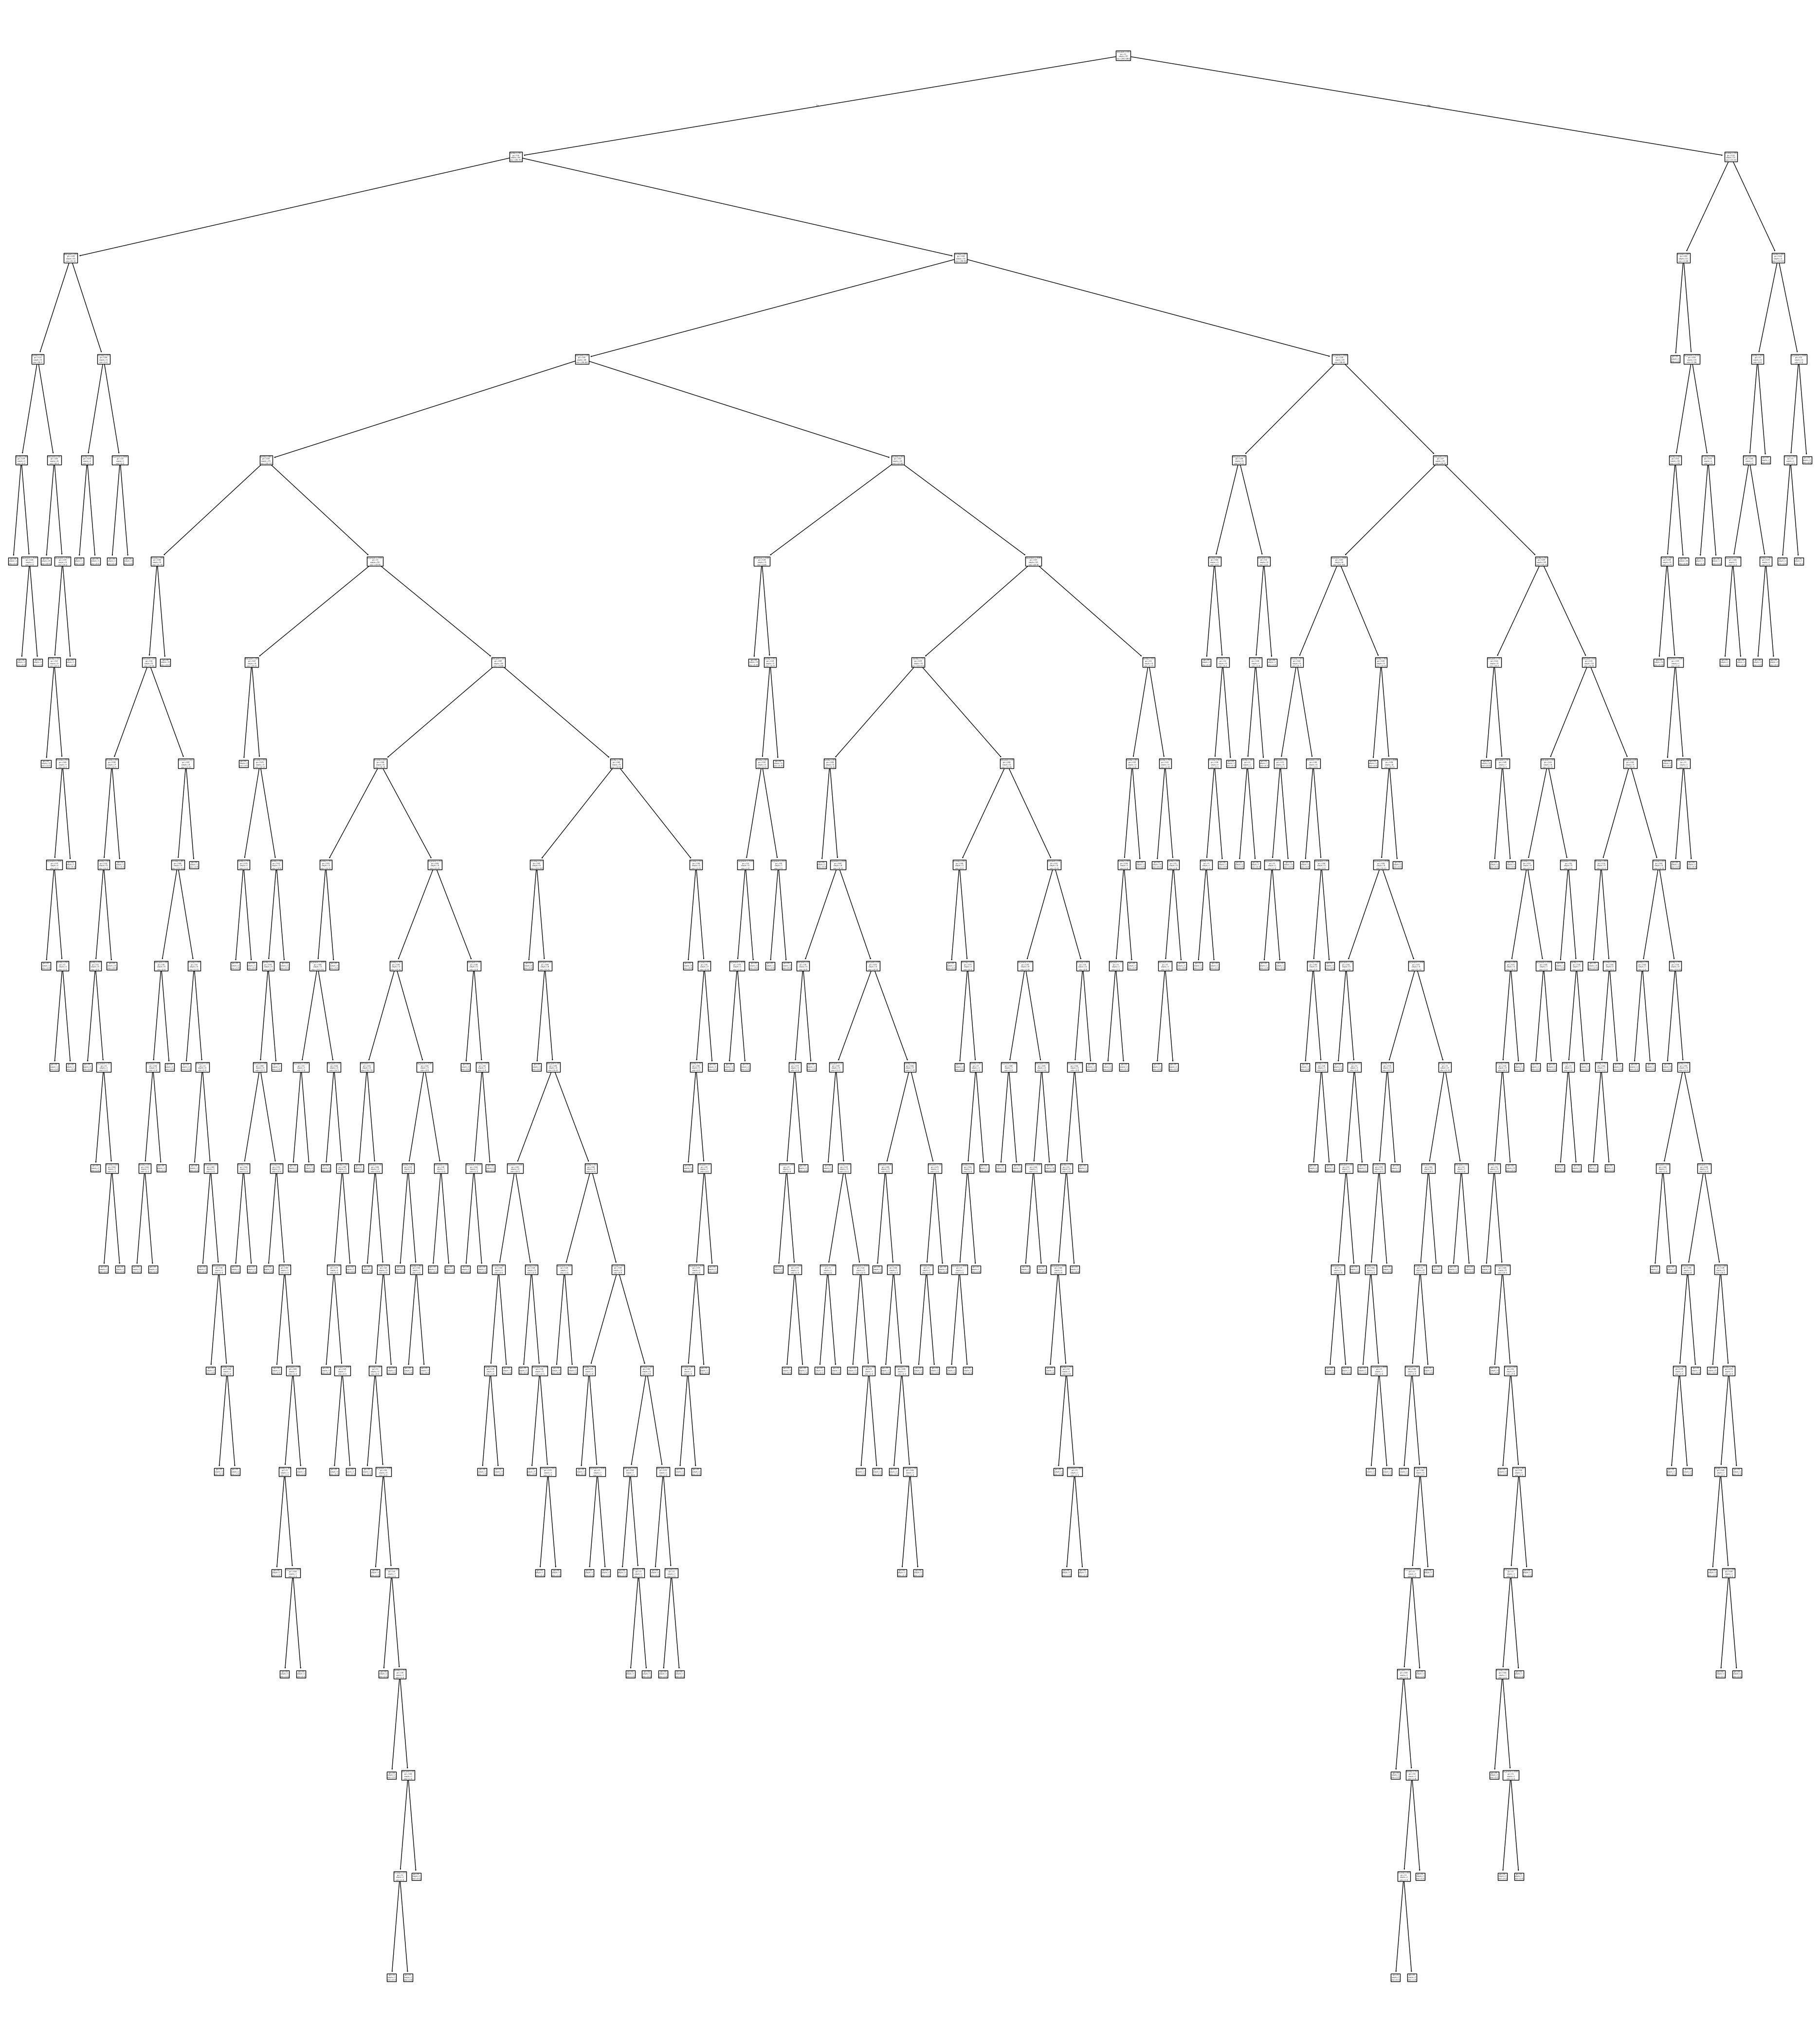

In [172]:
clf = DTC(criterion='gini', random_state=RNG_SEED)
clf.fit(X_train, y_train)

# Plot the unpruned tree
fig, ax = subplots(figsize=(48,54))
plot_tree(clf,
          feature_names=predictors,
          ax=ax);

fig.savefig("fig7.png")

err_unp_train = 1 - accuracy_score(y_train, clf.predict(X_train))
err_bayes_train = 1 - accuracy_score(y_train, ['No'] * len(y_train))

print("Unpruned Model Training Error: " + str(err_unp_train))
print("Naive Bayes Training Error: " + str(err_bayes_train))

In [173]:
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)
grid_ccp = skm.GridSearchCV(clf,
                            {'ccp_alpha': ccp_path.ccp_alphas},
                            refit=True,
                            cv=10,
                            scoring='accuracy')
grid_ccp.fit(X_train, y_train)

,estimator,DecisionTreeC...dom_state=111)
,param_grid,{'ccp_alpha': array([0. ... 0.05756375])}
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [174]:
print("Best CV Error: " + str(1 - grid_ccp.best_score_))

Best CV Error: 0.28762886597938153


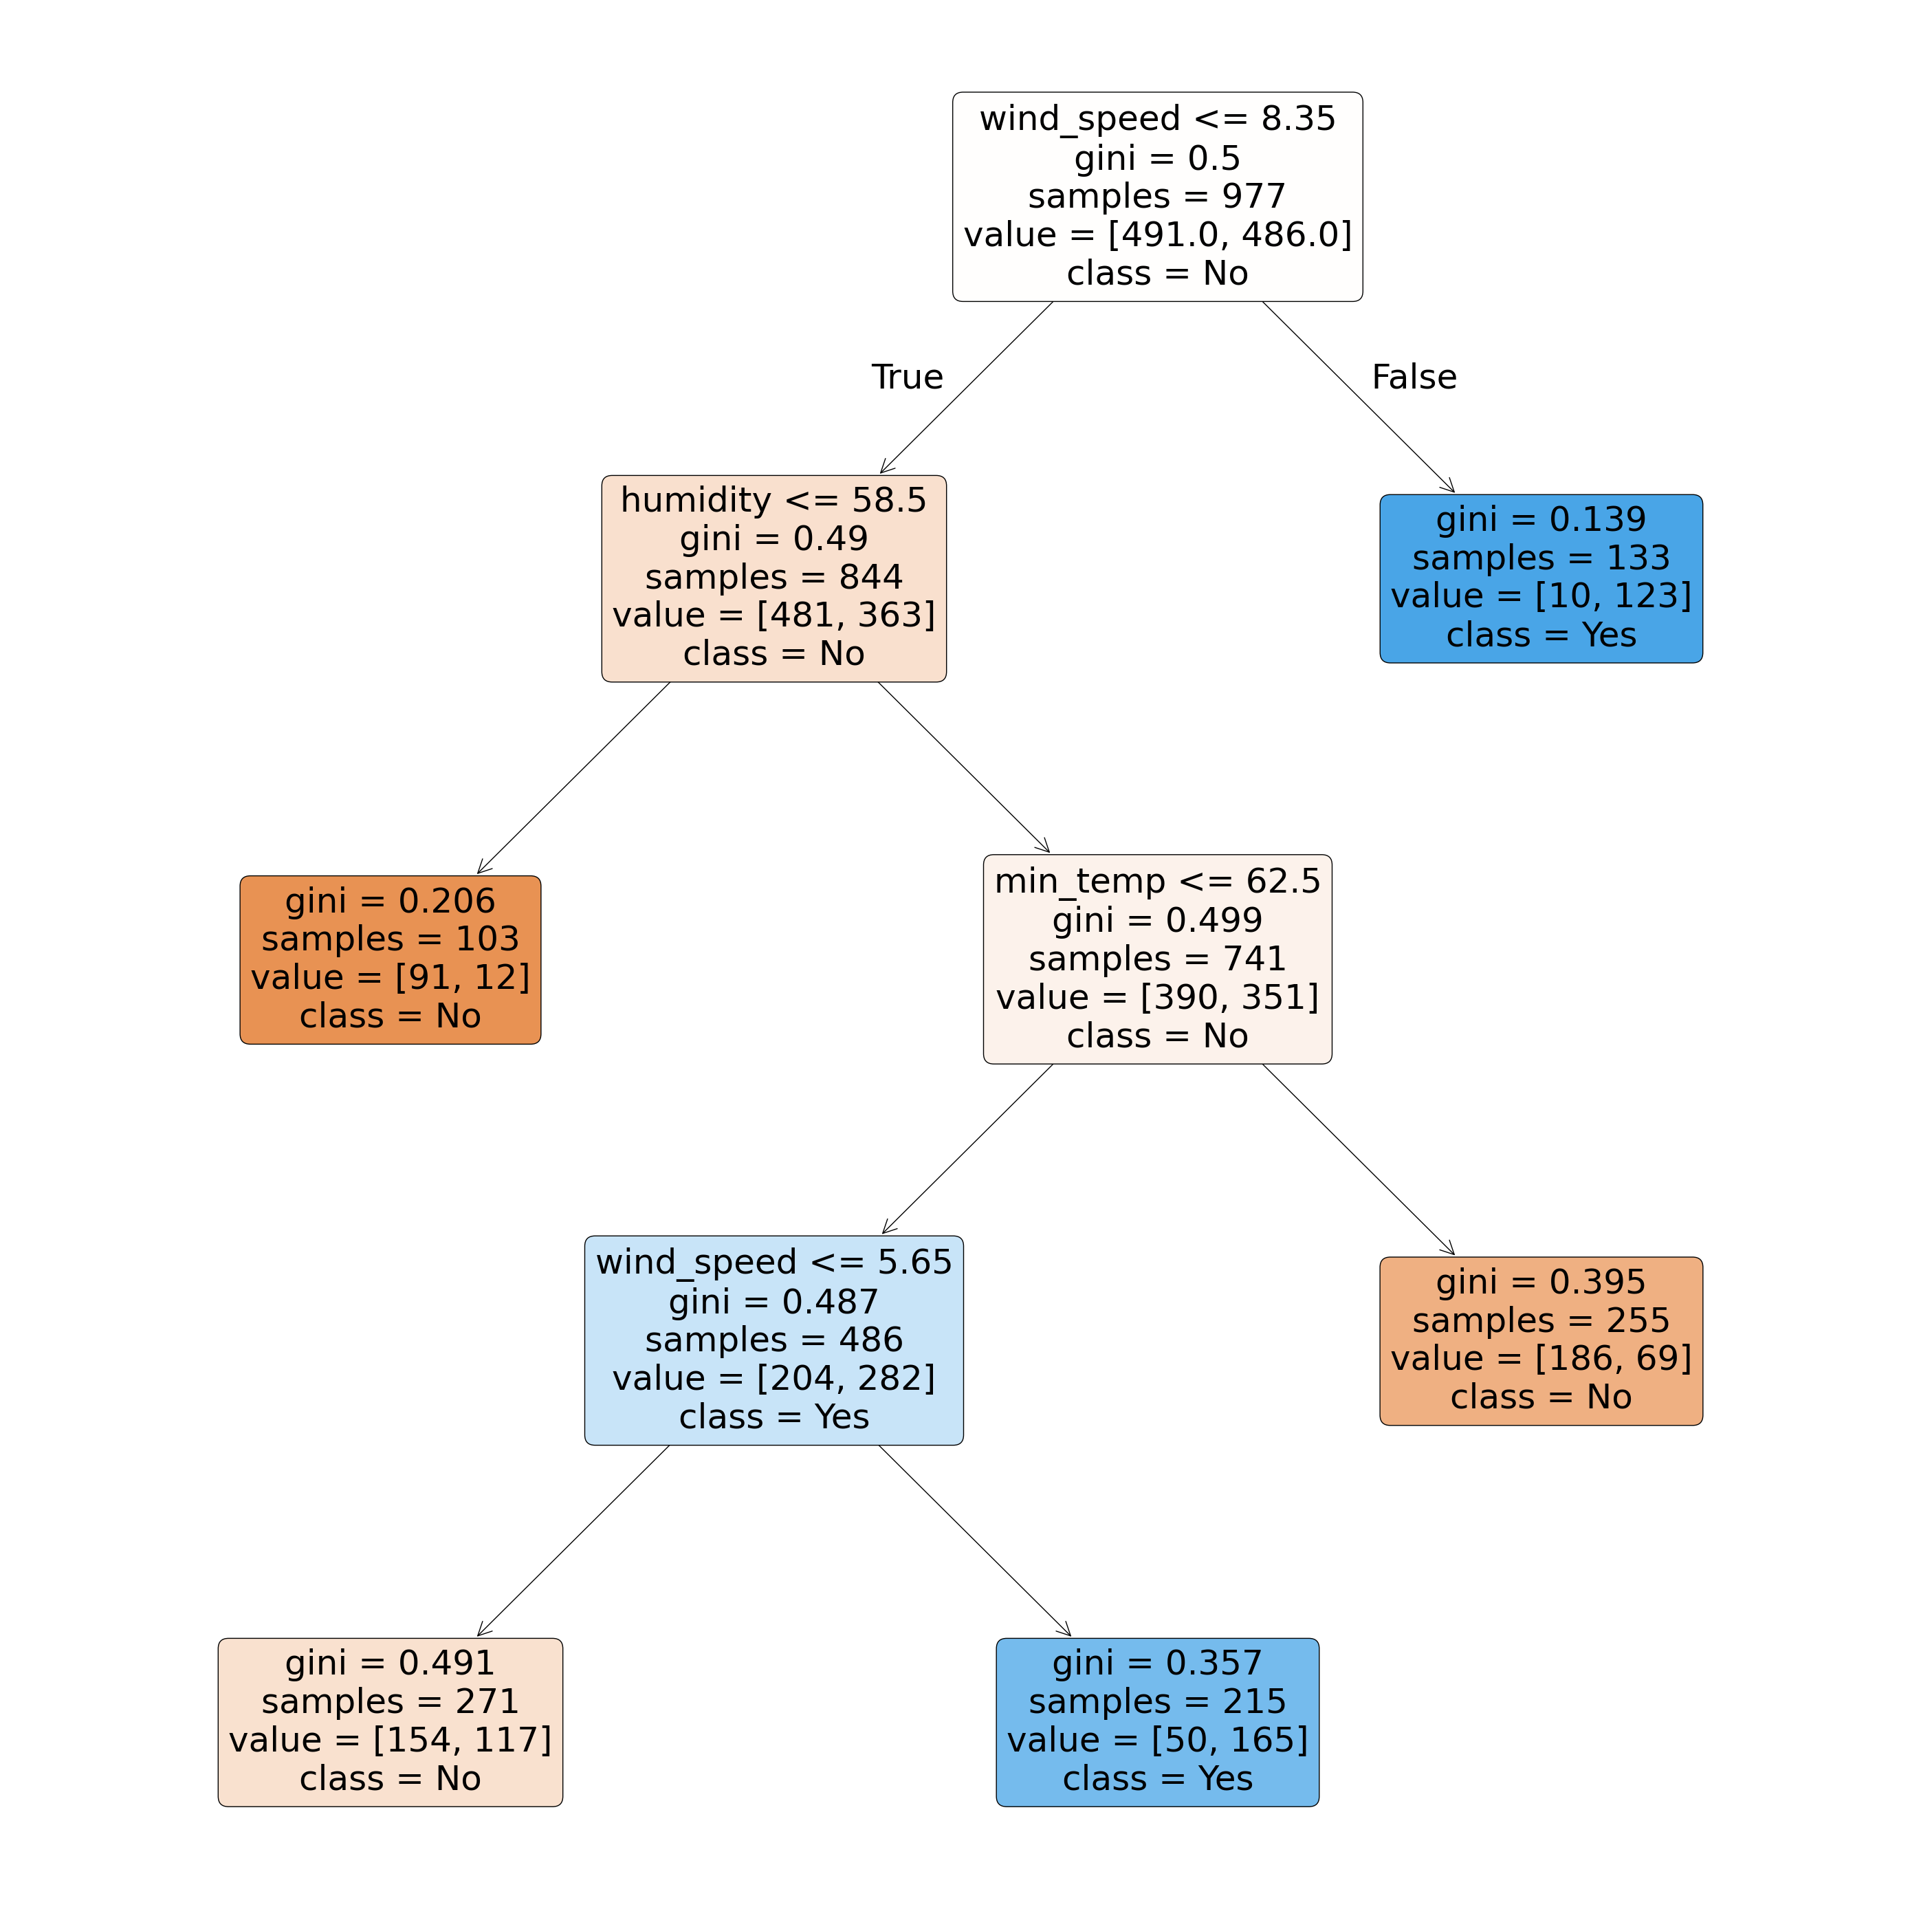

In [175]:
fig, ax = subplots(figsize=(36,36))
best_ccp = grid_ccp.best_estimator_
plot_tree(best_ccp,
          feature_names=predictors,
          ax=ax,
          class_names=['No', 'Yes'],
          rounded=True,
          filled=True,
         fontsize=36);
fig.savefig("fig8.png")

In [176]:
err_ccp_train = 1 - accuracy_score(y_train, best_ccp.predict(X_train))
err_ccp_test = 1 - accuracy_score(y_test, best_ccp.predict(X_test))
err_bayes_test = 1 - accuracy_score(y_test, ['Yes'] * len(y_test))

print("Model Training Error: " + str(err_ccp_train))
print("Naive Bayes Training Error: " + str(err_bayes_train))

print("Model Test Error: " + str(err_ccp_test))
print("Naive Bayes Test Error: " + str(err_bayes_test))
confusion_ccp = confusion_matrix(best_ccp.predict(X_test),
                                 y_test)


confusion_ccp

Model Training Error: 0.26407369498464683
Naive Bayes Training Error: 0.4974411463664279
Model Test Error: 0.273469387755102
Naive Bayes Test Error: 0.4897959183673469


array([[105,  52],
       [ 15,  73]])

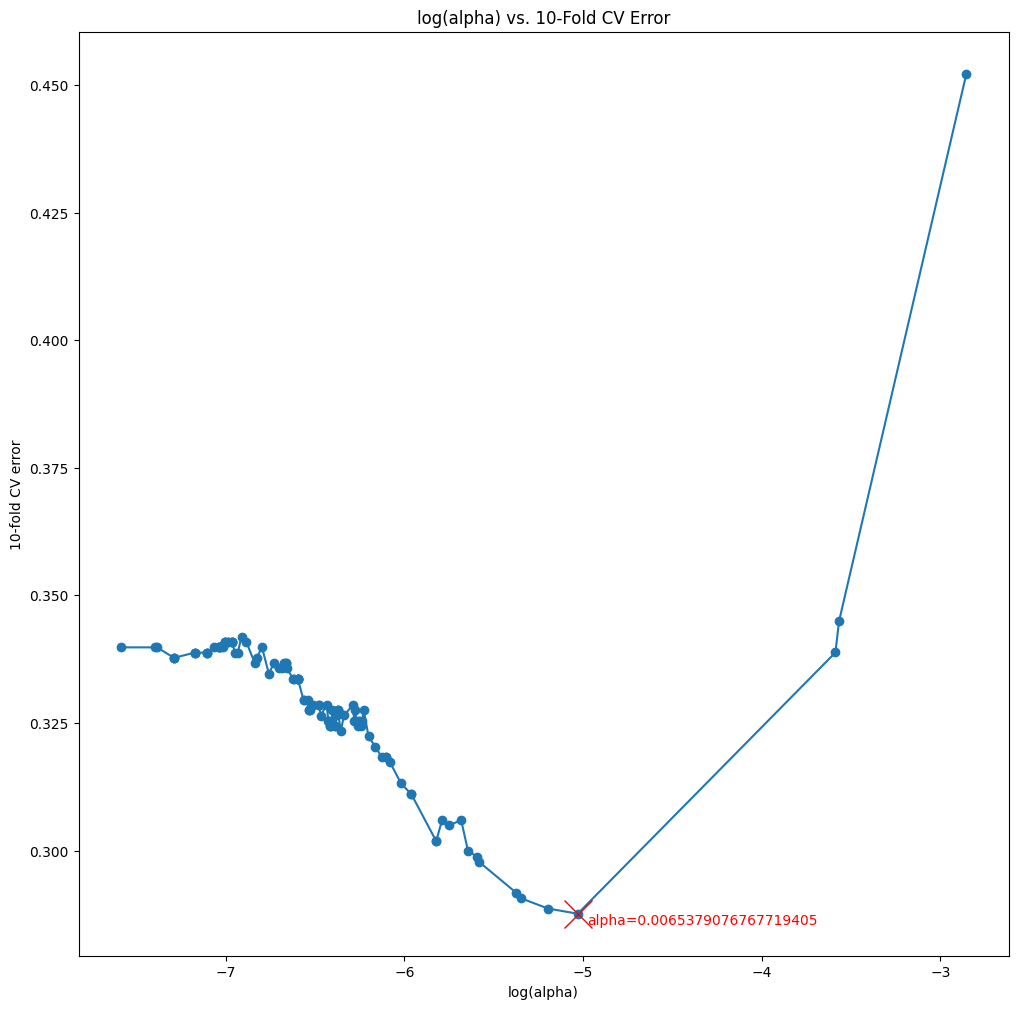

In [177]:
cv_df_ccp = pd.DataFrame(grid_ccp.cv_results_)
alpha_list = np.log([alpha_dict['ccp_alpha'] for alpha_dict in cv_df_ccp['params'][1::]])
err_list = [1 - acc for acc in cv_df_ccp['mean_test_score'][1::]]
min_err = min(err_list)
min_ind = err_list.index(min_err)
best_alpha = alpha_list[min_ind]

plt.figure(figsize=(12,12))

plt.plot(alpha_list, err_list, marker='o')
plt.plot(best_alpha, min_err, marker='x', markersize=20, color='red')
plt.text(best_alpha+0.05, min_err - 0.002, "alpha=" + str(np.exp(best_alpha)), fontsize=10, color='red')
plt.xlabel("log(alpha)"); plt.ylabel("10-fold CV error"); plt.title("log(alpha) vs. 10-Fold CV Error")
plt.savefig("fig15.png");
plt.show();




# Feature Importance for CPP Model

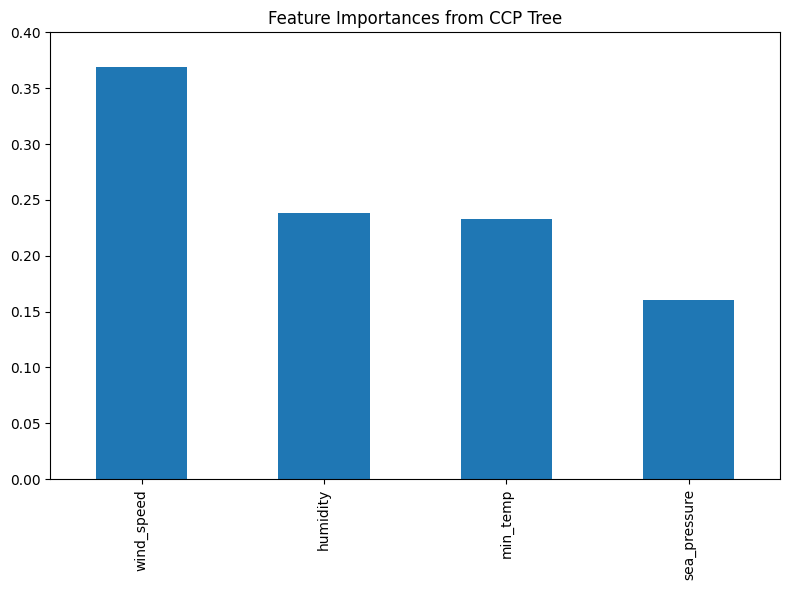

In [178]:
imp_ccp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
imp_ccp.plot(kind='bar')
plt.title("Feature Importances from CCP Tree")
plt.ylim(0, 0.4)
plt.tight_layout()
plt.savefig("fig3.png")
plt.show()

# Bagging

In [179]:
y_train_bin_s = [1 if will_rain == 'Yes' else 0 for will_rain in y_train_s]

bagger_s = BC(estimator = DTC(random_state=RNG_SEED),
              n_estimators=200,
              bootstrap=True,
              oob_score=True,
              random_state=RNG_SEED+1,
              n_jobs=-1)

bagger_s.fit(X_train_s, y_train_bin_s)
yhat_test_bag_s = bagger_s.predict(X_test_s)
prob_test_bag_s = bagger_s.predict_proba(X_test_s)[:,1]

print("Done.")

Done.


In [180]:
y_test_bin_s = [1 if will_rain == 'Yes' else 0 for will_rain in y_test_s]

err_bag_train_s = 1 - accuracy_score(y_train_bin_s, bagger_s.predict(X_train_s))
err_bag_test_s = 1 - accuracy_score(y_test_bin_s, bagger_s.predict(X_test_s))

print("Bagging Training Error: " + str(err_bag_train_s))
print("Naive Bayes Training Error: " + str(err_bayes_train_s))

print("Bagging Test Error: " + str(err_bag_test_s))
print("Naive Bayes Test Error: " + str(err_bayes_test_s))
confusion_bag = confusion_matrix(bagger_s.predict(X_test_s),
                                 y_test_bin_s)


confusion_bag

Bagging Training Error: 0.0
Naive Bayes Training Error: 0.4980793854033291
Bagging Test Error: 0.2602040816326531
Naive Bayes Test Error: 0.47959183673469385


array([[73, 22],
       [29, 72]])

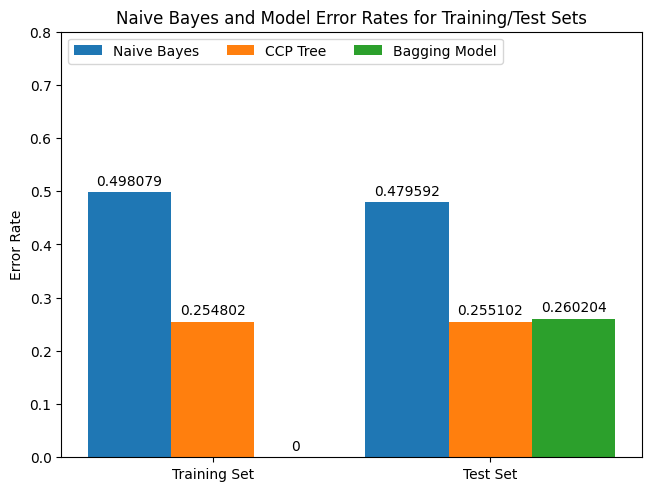

In [181]:
error_sets_bag_s = ("Training Set", "Test Set")
errors_bag_s = {
    'Naive Bayes': (err_bayes_train_s, err_bayes_test_s),
    'CCP Tree': (err_ccp_train_s, err_ccp_test_s),
    'Bagging Model': (err_bag_train_s, err_bag_test_s)
}

x = np.arange(len(error_sets_bag_s))
width = 0.3
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in errors_bag_s.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Error Rate')
ax.set_title('Naive Bayes and Model Error Rates for Training/Test Sets')
ax.set_xticks(x + width, error_sets_bag_s)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 0.8)
fig.savefig("fig5.png")

plt.show()

# Bagging ROC-AUC

Test ROC-AUC: 0.8262932832707551


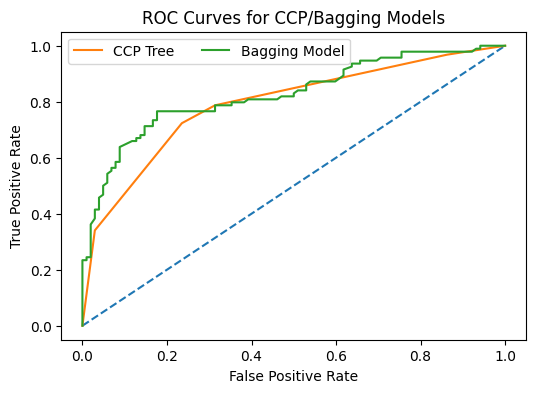

In [76]:
auc_bag = roc_auc_score(y_test_s, prob_test_bag_s)
print("Test ROC-AUC: " + str(roc_auc_score(y_test_s, prob_test_bag_s)))

fpr_bag, tpr_bag = roc_curve(y_test_s, prob_test_bag_s,
                             pos_label="Yes")[:2]
fig, ax = subplots(figsize=(6,4))
ax.plot([0,1], [0,1], linestyle='--')
ax.plot(fpr_ccp, tpr_ccp, label="CCP Tree")
ax.plot(fpr_bag, tpr_bag, label="Bagging Model")
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
ax.set_title("ROC Curves for CCP/Bagging Models")
ax.legend(loc='upper left', ncols=2)
fig.savefig("fig11.png")

plt.show()

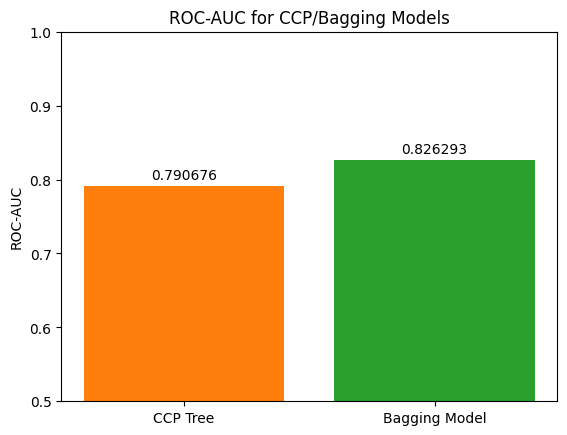

In [89]:
model_names = ["CCP Tree", "Bagging Model"]
aucs = [auc_ccp, auc_bag]
colors = ['tab:orange', 'tab:green']

fig, ax = plt.subplots()

ax.bar_label(ax.bar(model_names, aucs, color=colors), padding=3)
ax.set_ylabel('ROC-AUC')
ax.set_title('ROC-AUC for CCP/Bagging Models')
ax.set_ylim(0.5, 1)
fig.savefig("fig13.png")

plt.show()

# Bagging Model fit to Entire Training Set

In [45]:
y_train_bin = [1 if will_rain == 'Yes' else 0 for will_rain in y_train]

bagger = BC(
    estimator = DTC(random_state=RNG_SEED),
    n_estimators=500,
    bootstrap=True,
    oob_score=True,
    random_state=RNG_SEED+1,
    n_jobs=-1)

bagger.fit(X_train, y_train_bin)
yhat_test_bag = bagger.predict(X_test)
prob_test_bag = bagger.predict_proba(X_test)[:,1]

# bag_cv = validation_curve(bagger,
#                           X_train,
#                           y_train_bin,
#                           param_name = 'n_estimators',
#                           param_range=range(1,201),
#                           cv=10,
#                           n_jobs=-1)
print("Done.")
                        

Done.


In [46]:
# np.savetxt('bagging_cv_data_train.csv', [np.array(range(1,11))] + list(bag_cv[0]), delimiter=',')
# np.savetxt('bagging_cv_data_test.csv', [np.array(range(1,11))] + list(bag_cv[1]), delimiter=',')

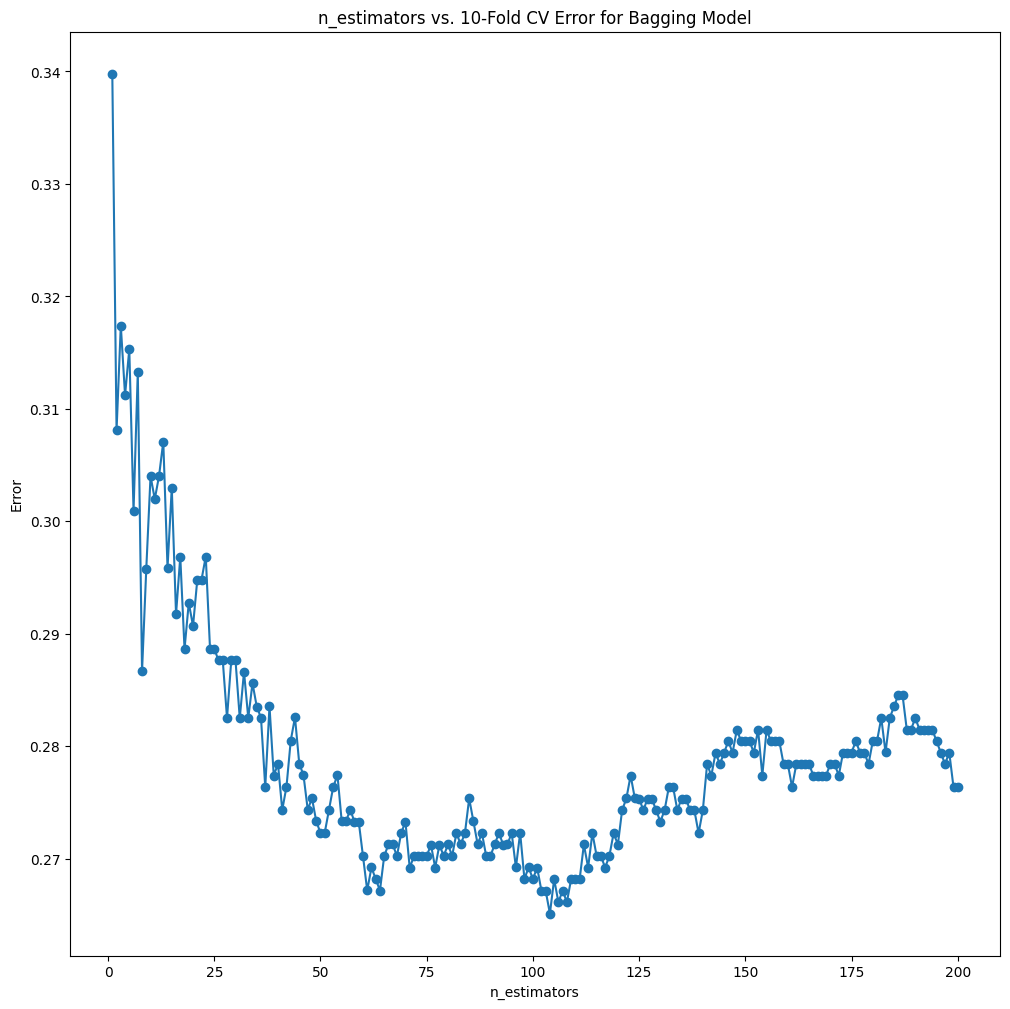

In [47]:
cv_df_bag = pd.read_csv('bagging_cv_data_test.csv')
cv_list_bag = [1 - acc for acc in cv_df_bag.mean(axis=1)]

fig, ax = plt.subplots(figsize=(12,12))

ax.plot(range(1,201), cv_list_bag, marker='o')
ax.set_xlabel("n_estimators");
ax.set_ylabel("Error");
ax.set_title("n_estimators vs. 10-Fold CV Error for Bagging Model")
fig.savefig("fig10.png");

In [48]:
bag_cv = 1 - np.mean(
                cross_val_score(bagger,
                                X_train,
                                y_train_bin,
                                cv=10,
                                n_jobs=-1))
bag_oob = 1 - bagger.oob_score_

print("Bagging CV Error:", bag_cv)
print("Bagging OOB Error:", bag_oob)

Bagging CV Error: 0.2753313696612666
Bagging OOB Error: 0.28454452405322417


In [51]:
y_test_bin = [1 if will_rain == 'Yes' else 0 for will_rain in y_test]

err_bag_train = 1 - accuracy_score(y_train_bin, bagger.predict(X_train))
err_bag_test = 1 - accuracy_score(y_test_bin, bagger.predict(X_test))

print("Bagging Training Error: " + str(err_bag_train))
print("Naive Bayes Training Error: " + str(err_bayes_train))

print("Bagging Test Error: " + str(err_bag_test))
print("Naive Bayes Test Error: " + str(err_bayes_test))
confusion_bag = confusion_matrix(bagger.predict(X_test),
                                 y_test_bin)


confusion_bag

Bagging Training Error: 0.0
Naive Bayes Training Error: 0.4974411463664279
Bagging Test Error: 0.24897959183673468
Naive Bayes Test Error: 0.4897959183673469


array([[93, 34],
       [27, 91]])

# Feature Importance for Bagging Model

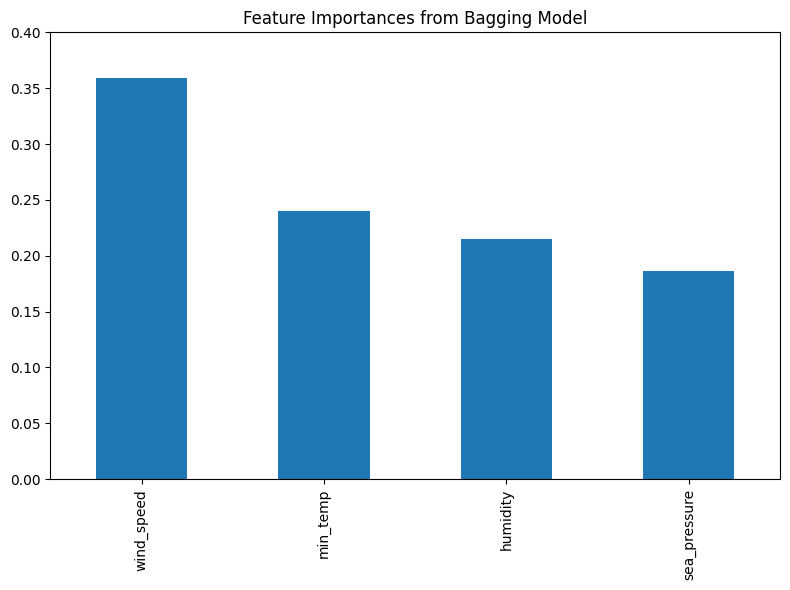

In [156]:
imp_bag = pd.Series(np.mean(
            [est.feature_importances_ for est in bagger.estimators_],
            axis=0), index=X.columns
          ).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
imp_bag.plot(kind='bar')
plt.title("Feature Importances from Bagging Model")
plt.ylim(0, 0.4)
plt.tight_layout()
plt.savefig("fig12.png")
plt.show()

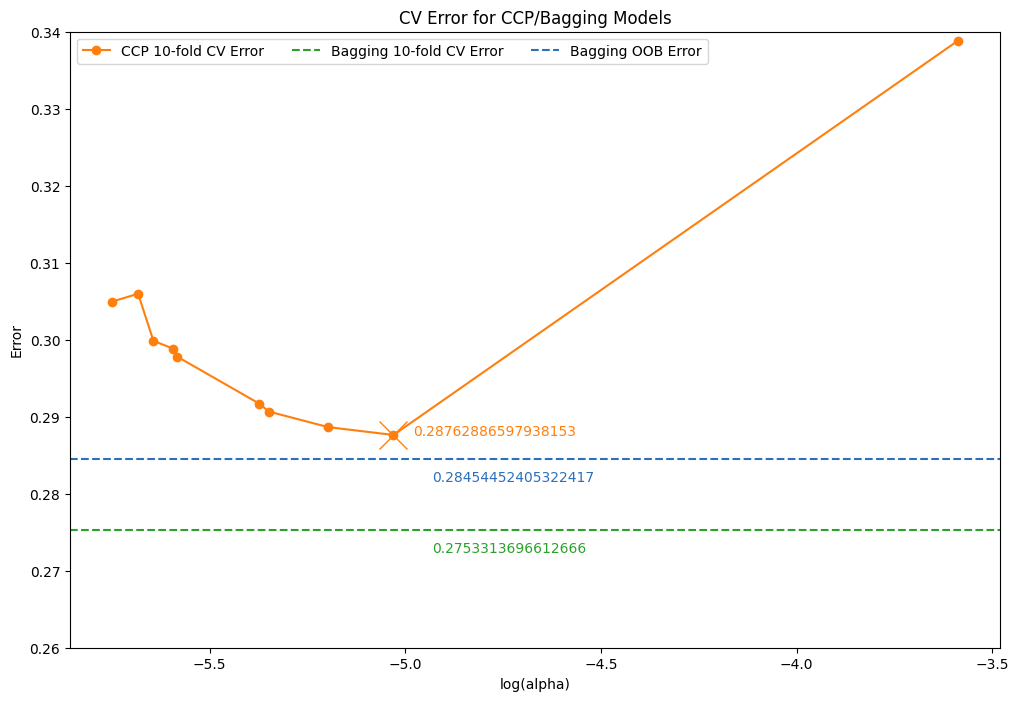

In [137]:
short_alpha_list = alpha_list[-3:-13:-1]
short_err_list = err_list[-3:-13:-1]

plt.figure(figsize=(12,8))

plt.plot(short_alpha_list, short_err_list, marker='o', color='tab:orange', label='CCP 10-fold CV Error')
plt.plot(best_alpha, min_err, marker='x', markersize=20, color='tab:orange')
plt.axhline(y=bag_cv, color='tab:green', linestyle='--', label='Bagging 10-fold CV Error')
plt.axhline(y=bag_oob, color='#2c6fbb', linestyle='--', label='Bagging OOB Error')
plt.text(best_alpha+0.05, min_err, str(min_err), fontsize=10, color='tab:orange')
plt.text(best_alpha+0.1, bag_cv - 0.003, str(bag_cv), fontsize=10, color='tab:green')
plt.text(best_alpha+0.1, bag_oob - 0.003, str(bag_oob), fontsize=10, color='#2c6fbb')
plt.xlabel("log(alpha)"); plt.ylabel("Error"); plt.title("CV Error for CCP/Bagging Models")
plt.legend(loc='upper left', ncols=3)
plt.ylim(0.26, 0.34)
plt.savefig("fig14.png");
plt.show();



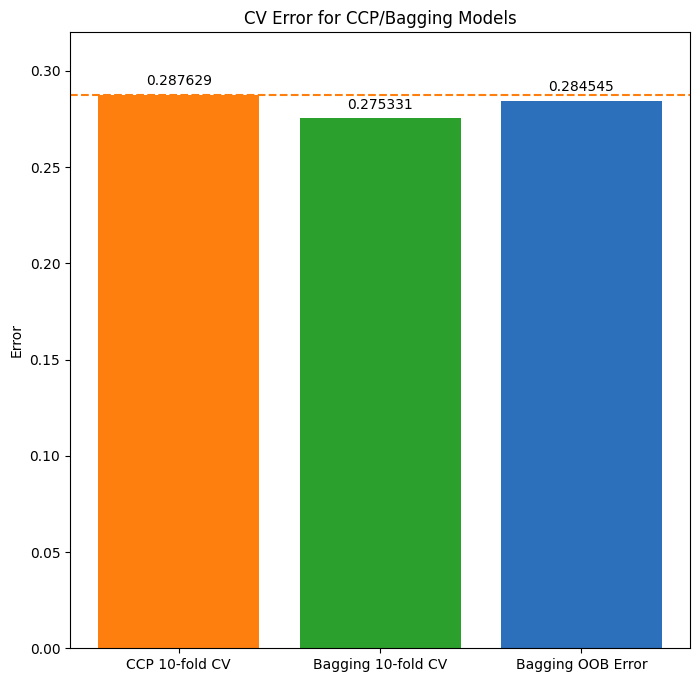

In [146]:
err_names = ["CCP 10-fold CV", "Bagging 10-fold CV", "Bagging OOB Error"]
errs = [min_err, bag_cv, bag_oob]
colors_err = ['tab:orange', 'tab:green', '#2c6fbb']

fig, ax = plt.subplots(figsize=(8,8))

ax.bar_label(ax.bar(err_names, errs, color=colors_err), padding=4.5)
ax.set_ylabel('Error')
ax.set_title('CV Error for CCP/Bagging Models')
ax.set_ylim(0, 0.32)
ax.axhline(y=min_err, color='tab:orange', linestyle='--', )
fig.savefig("fig13.png")

plt.show()

# Comparing Models with AIC
